In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pendulum
from sklearn.model_selection import train_test_split
from energy_usage import energy_used

Reading json file...
Opened messages from json


In [2]:
ONPEAK_HOURS = [7,8,9,10,11] + [16,17,18,19]

df_raw = pd.read_csv('weather_data.csv', header=4)
df_raw['Year'] = [2000+int(x.split('/')[-1]) for x in list(df_raw['Date'])]
df_raw['HourlyDryBulbTemperature'] = pd.to_numeric(df_raw['HourlyDryBulbTemperature'], errors='coerce')
df_raw['HourlyWetBulbTemperature'] = pd.to_numeric(df_raw['HourlyWetBulbTemperature'], errors='coerce')
df_raw['HourlyWindSpeed'] = pd.to_numeric(df_raw['HourlyWindSpeed'], errors='coerce')
df_raw['HourlyWindGustSpeed'] = pd.to_numeric(df_raw['HourlyWindGustSpeed'], errors='coerce')
df_raw['HourlyWindDirection'] = pd.to_numeric(df_raw['HourlyWindDirection'], errors='coerce')
df_raw['HourlyPrecipitation'] = pd.to_numeric(df_raw['HourlyPrecipitation'], errors='coerce')
df_raw['HourlyRelativeHumidity'] = pd.to_numeric(df_raw['HourlyRelativeHumidity'], errors='coerce')
df_raw['HourlyStationPressure'] = pd.to_numeric(df_raw['HourlyStationPressure'], errors='coerce')

clean_data = {
    'date': [x for x in list(df_raw['DATE'])],
    'oat_dry': [x for x in list(df_raw['HourlyDryBulbTemperature'])],
    'oat_wet': [x for x in list(df_raw['HourlyWetBulbTemperature'])],
    'wind_speed': [x for x in list(df_raw['HourlyWindSpeed'])],
    'wind_gust_speed': [0 if pd.isna(x) else x for x in list(df_raw['HourlyWindGustSpeed'])],
    'wind_direction': [0 if pd.isna(x) else x for x in list(df_raw['HourlyWindDirection'])],
    'precipitation': [x for x in list(df_raw['HourlyPrecipitation'])],
    'humidity': [x for x in list(df_raw['HourlyRelativeHumidity'])],
    'pressure': [x for x in list(df_raw['HourlyStationPressure'])],
}

df = pd.DataFrame(clean_data)

# Add sky conditions
all_codes = ['BKN', 'OVC', 'VV', 'SCT', 'FEW', 'CLR']
sky_conditions = {}
for code in all_codes:
    sky_conditions[code] = [0]*len(df_raw)
for k in range(len(df_raw)):
    x = str(df_raw['HourlySkyConditions'][k])
    for i in range(x.count(':')):
        sky_conditions[x.split(':')[i][-3:]][k] = 1
for key in sky_conditions:
    df[key] = sky_conditions[key]

# plt.scatter(range(len(df)), df['date'].dt.minute)
# plt.show()

# Group data by hour, taking the mean
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M:%S')
df['date_grouped'] = df['date'].dt.strftime('%Y-%m-%d %H')
df = df.groupby('date_grouped').mean()
df.reset_index(inplace=True, drop=True)
df = df.round(1)

# Drop rows which contain NaNs
num_nans = len(df)
df = df.dropna()
num_nans = num_nans - len(df)
print(f"There were {num_nans} rows with NaNs")

# Only keep data for the selected time
df_backup = df.copy()
df = df[df['date'] >= pendulum.datetime(2024, 12, 3, tz='America/New_York').naive()]
# df = df[df['date'] <= pendulum.datetime(2024, 12, 5, tz='America/New_York').naive()]
df = df[df['date'].dt.hour.isin(ONPEAK_HOURS)]
df.reset_index(inplace=True, drop=True)

# Find the energy used
df['energy'] = df.apply(lambda row: 
                             energy_used('beech', row['date'].year, row['date'].month, row['date'].day, row['date'].hour), 
                             axis=1
                             )
df['date'] = df['date'].dt.floor('h')

# Drop rows which contain NaNs again
num_nans = len(df)
df = df.dropna()
num_nans = num_nans - len(df)
print(f"There were {num_nans} rows with NaNs")

# Process binary columns
binary_columns = [x for x in df.columns if x in all_codes]
for col in binary_columns:
    df[col] = df[col].round().astype('category')

# print(df)

df_backup = df.copy()

/var/folders/1m/zr3l918x2s76ccl63lx5cst40000gn/T/ipykernel_18760/3158036955.py:3: DtypeWarning: Columns (8,26,32,33,34,35,37,38,47,48,49,55,57,64,65,75,77,94,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('weather_data.csv', header=4)


There were 2053 rows with NaNs
No data found
No data found
There were 27 rows with NaNs


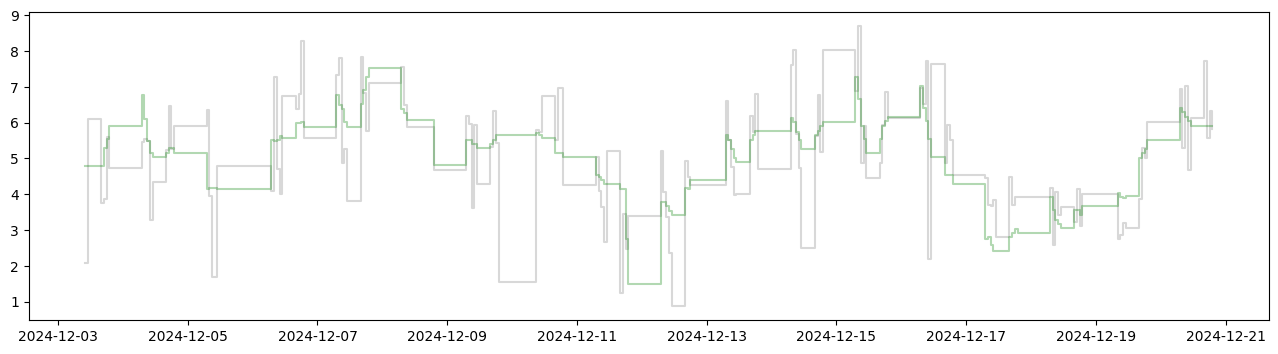

In [3]:
df = df_backup.copy()
df = df[df['date'] <= pendulum.datetime(2025, 1, 1, 0, tz='America/New_York').naive()]

# Split training and testing data
features = [col for col in df.columns if col not in ['energy', 'date'] and 'energy' not in col]
X = df[[col for col in df.columns if 'energy' not in col and 'date' not in col]]
y = df['energy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test, df.loc[X_test.index, 'date']], axis=1)
test_df = df.copy()

# Predict energy used
import statsmodels.formula.api as smf
formula = 'energy ~ oat_dry + wind_speed'
mod = smf.ols(formula=formula, data=train_df)
res = mod.fit()
alpha = res.params.Intercept
beta = res.params.oat_dry
gamma = res.params.wind_speed
test_df['energy_pred_alpha'] = test_df.apply(lambda row: alpha + beta*row['oat_dry'] + gamma*row['wind_speed'], axis=1)
test_df = test_df.sort_values(by='date')

plt.figure(figsize=(16,4))
plt.step(test_df.date, test_df.energy, where='post', color='gray', alpha=0.3)
plt.step(test_df.date, test_df.energy_pred_alpha, where='post', color='green', alpha=0.3)
plt.show()

In [4]:
test_df['degF_above_end_temp'] = test_df.apply(lambda row: 
                                         energy_used('beech', row['date'].year, row['date'].month, row['date'].day, row['date'].hour, above_setpoint=True), 
                                         axis=1)

# Find the thermal mass of the house that minimizes the residuals
rmses = []
for thermal_mass in range(0, 250, 10):

    thermal_mass = thermal_mass/100

    # At the start of the hour, how much extra heat do we have in the room (compared to setpoint)
    test_df[f'energy_pred_alpha_{thermal_mass}'] = test_df['energy_pred_alpha'] - test_df['degF_above_end_temp'] * thermal_mass

    # Compute the RMSE between predicted and used energy
    rmse = round(((test_df['energy'] - test_df[f'energy_pred_alpha_{thermal_mass}'])**2).mean()**0.5,2)
    rmses.append(rmse)
    # print(f"{thermal_mass}: {rmse}")

Text(0, 0.5, 'RMSE [kWh]')

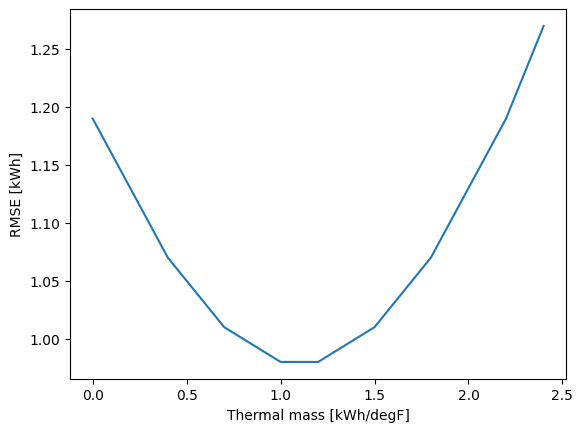

In [5]:
plt.plot([x/100 for x in range(0, 250, 10)], rmses)
plt.xlabel(f'Thermal mass [kWh/degF]')
plt.ylabel(f'RMSE [kWh]')

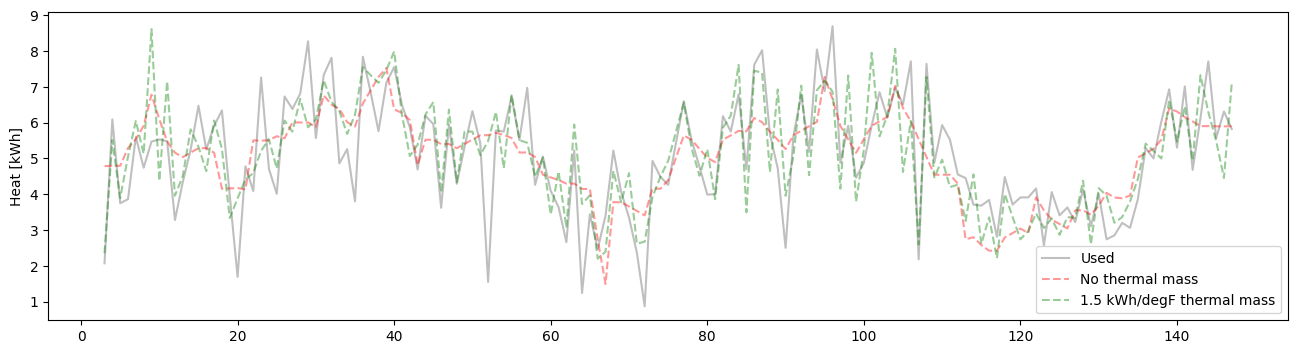

In [18]:
plt.figure(figsize=(16,4))
plt.plot(test_df.energy, color='gray', alpha=0.5, label='Used')
plt.plot(test_df.energy_pred_alpha, color='red', alpha=0.4, linestyle='dashed', label='No thermal mass')
plt.plot(test_df['energy_pred_alpha_1.5'], color='green', alpha=0.4, linestyle='dashed', label='1.5 kWh/degF thermal mass')
plt.ylabel('Heat [kWh]')
plt.legend()
plt.show()

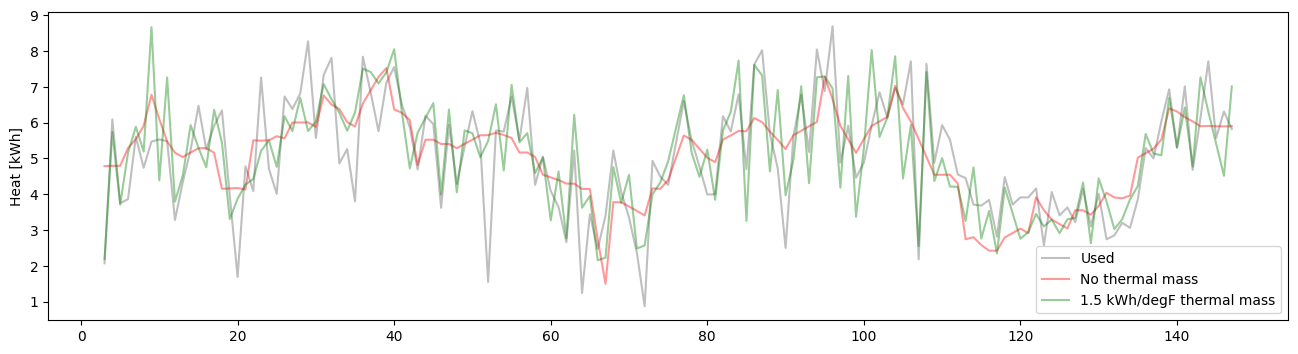

In [13]:
thermal_mass = 1.5
df['energy_pred_alpha'] = df.apply(lambda row: alpha + beta*row['oat_dry'] + gamma*row['wind_speed'], axis=1)
df['degF_above_end_temp'] = df.apply(lambda row: 
                                         energy_used('beech', row['date'].year, row['date'].month, row['date'].day, row['date'].hour, above_setpoint=True), 
                                         axis=1)
df[f'energy_pred_alpha_{thermal_mass}'] = df['energy_pred_alpha'] - df['degF_above_end_temp'] * thermal_mass

plt.figure(figsize=(16,4))
plt.plot(df.energy, color='gray', alpha=0.5, label='Used')
plt.plot(df.energy_pred_alpha, color='red', alpha=0.4, label='No thermal mass')
plt.plot(df[f'energy_pred_alpha_{thermal_mass}'], color='green', alpha=0.4, label='1.5 kWh/degF thermal mass')
plt.ylabel('Heat [kWh]')
plt.legend()
plt.savefig('test.png',dpi=500)
plt.show()

In [15]:
alpha

8.26797881320744

In [16]:
beta

-0.12412909167569795

In [17]:
gamma

-0.00208788093480861

In [8]:

# import time
# start_time = time.time()

# for kwh in [125]:#range(50,200,25):
#     kwh = kwh/100
#     print(kwh)

#     # Update the energy column in both the training and testing set
#     df['energy'] = df.apply(lambda row: 
#                              energy_used('beech', row['date'].year, row['date'].month, row['date'].day, row['date'].hour, thermal_mass=kwh), 
#                              axis=1
#                              )
    
#     print(f"{start_time-time.time()}")
    
#     # Split training and testing data
#     features = [col for col in df.columns if col not in ['energy', 'date', 'energy_pred_alpha'] and 'energy' not in col]
#     X = df[features]
#     y = df['energy']
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
#     train_df = pd.concat([X_train, y_train], axis=1)
#     test_df = pd.concat([X_test, y_test, df.loc[X_test.index, 'date']], axis=1)

#     # Fit the model on the training data
#     import statsmodels.formula.api as smf
#     formula = 'energy ~ oat_dry + wind_speed'
#     mod = smf.ols(formula=formula, data=train_df)
#     res = mod.fit()
#     print(res.summary())

#     # DATES FOR THE PLOT ----------------------------
#     # DATES FOR THE PLOT ----------------------------
#     # df = df[df['date'] >= pendulum.datetime(2025, 1, 10, 0, tz='America/New_York').naive()]
#     # df = df[df['date'] <= pendulum.datetime(2025, 1, 1, 0, tz='America/New_York').naive()]
#     # DATES FOR THE PLOT ----------------------------
#     # DATES FOR THE PLOT ----------------------------

#     # Predict the testing data
#     test_df = df.copy()
#     test_df['energy_pred_reg'] = res.predict(test_df)
#     df = df.sort_values(by='date')

#     # Plot
#     color = 'tab:blue' if kwh==0 else 'tab:orange'
#     line_style='-'
#     plt.plot(test_df.date, test_df.energy, line_style, label=f'used - {kwh} kWh/degF', alpha=0.4, color=color)
#     rmse_reg = round(((test_df['energy'] - test_df['energy_pred_reg'])**2).mean()**0.5,2)
#     print(rmse_reg)
#     plt.plot(test_df.date, test_df.energy_pred_reg, linestyle='dashed', label=f'predicted - {kwh} kWh/degF, RMSE={rmse_reg}', alpha=0.6, color=color)

# plt.ylim([-0.1,16])
# plt.ylabel('Heat [kWh]')
# plt.legend()
# plt.show()

In [9]:


# # Using random forests
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=2)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

# Predict on the testing data
# test_df = df.copy()
# test_df['energy_pred_reg'] = res.predict(test_df)
# # test_df['energy_pred_rf'] = rf_regressor.predict(test_df[features])
# test_df['energy_pred_alpha'] = test_df.apply(lambda row: energy_alpha_pred(row['oat_dry'], row['wind_speed']), axis=1)
# test_df = test_df.sort_values(by='date')

# plt.figure(figsize=(16,4))
# plt.plot(test_df.date, test_df.energy, '-o', label='used', alpha=0.7, color='gray')
# plt.scatter(test_df.date, test_df.energy_pred_alpha, label='predicted - alpha', alpha=0.7)
# plt.scatter(test_df.date, test_df.energy_pred_reg, label='predicted - new', alpha=0.7)
# # plt.scatter(test_df.date, test_df.energy_pred_rf, label='predicted - rf', alpha=0.7)

# # for day in test_df.date.dt.date.unique():
# #     start_time = pd.to_datetime(day).replace(hour=7, minute=0, second=0, microsecond=0)
# #     end_time = pd.to_datetime(day).replace(hour=12, minute=0, second=0, microsecond=0)
# #     plt.axvspan(start_time, end_time, color='gray', alpha=0.1)

# # for day in test_df.date.dt.date.unique():
# #     start_time = pd.to_datetime(day).replace(hour=16, minute=0, second=0, microsecond=0)
# #     end_time = pd.to_datetime(day).replace(hour=20, minute=0, second=0, microsecond=0)
# #     plt.axvspan(start_time, end_time, color='gray', alpha=0.1)

# plt.ylim([-0.1,16])
# plt.ylabel('Heat [kWh]')
# plt.legend()
# plt.show()

# # Plot weather
# plt.figure(figsize=(16,4))
# df_trick = df.copy()
# plt.plot(df_trick['date'], df_trick['oat_dry'], '-x', label="oat_dry")
# plt.plot(df_trick['date'], df_trick['oat_wet'], '-x', label="oat_wet")
# plt.plot(df_trick['date'], df_trick['wind_speed'], '-x', label="wind_speed")
# plt.plot(df_trick['date'], df_trick['wind_gust_speed'], '-x', label="wind_gust_speed")
# # plt.plot(df_trick['date'], df_trick['humidity'], '-x', label="humidity")
# # plt.plot(df_trick['date'], df_trick['wind_direction'], '-x', label="wind_direction")
# plt.plot(df_trick['date'], df_trick['FEW'], '-x', label="FEW")
# plt.ylabel('Various')
# plt.legend()
# plt.show()

# # Plot lines
# plt.figure(figsize=(16,4))
# line_style='-'
# plt.plot(test_df.date, test_df.energy, line_style, label='used', alpha=0.4, color='gray')
# rmse_alpha = round(((test_df['energy'] - test_df['energy_pred_alpha'])**2).mean()**0.5,2)
# rmse_reg = round(((test_df['energy'] - test_df['energy_pred_reg'])**2).mean()**0.5,2)
# # rmse_rf = round(((test_df['energy'] - test_df['energy_pred_rf'])**2).mean()**0.5,2)
# # plt.plot(test_df.date, test_df.energy_pred_alpha, line_style, label=f'predicted - alpha/beta/gamma, RMSE={rmse_alpha}', alpha=0.6)
# plt.plot(test_df.date, test_df.energy_pred_reg, line_style, label=f'predicted - new, RMSE={rmse_reg}', alpha=0.6)
# # plt.plot(test_df.date, test_df.energy_pred_rf, line_style, label=f'predicted - rf, RMSE={rmse_rf}', alpha=0.6)
# plt.ylim([-0.1,16])
# plt.ylabel('Heat [kWh]')
# plt.legend()
# plt.show()

In [10]:
# Get feature importances from the trained Random Forest model
feature_importances = rf_regressor.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
print(importance_df)

            feature  importance
0           oat_dry    0.362040
1           oat_wet    0.272672
2          humidity    0.084870
3          pressure    0.070744
4        wind_speed    0.056150
5    wind_direction    0.038373
6               BKN    0.032239
7   wind_gust_speed    0.024180
8               FEW    0.016142
9               OVC    0.015982
10              CLR    0.010563
11    precipitation    0.006211
12               VV    0.005251
13              SCT    0.004583


In [11]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Initialize the RFE with RandomForestRegressor as the estimator
selector = RFE(estimator=RandomForestRegressor(), n_features_to_select=1)

# Fit the RFE to the training data
selector.fit(X_train, y_train)

# Get the ranking of features (1 means the feature is the most important)
feature_ranking = pd.DataFrame({
    'Ranking': selector.ranking_,
    'Feature': X_train.columns,
})

# Sort by the ranking to see which features are most important
feature_ranking = feature_ranking.sort_values(by='Ranking')
display(feature_ranking)

# Get the selected features based on RFE
selected_features = X_train.columns[selector.support_]
print("Selected features:", selected_features)

# Reduce the features in the dataset
X_train_selected = X


,Ranking,Feature
0,1,oat_dry
1,2,oat_wet
6,3,humidity
2,4,wind_speed
7,5,pressure
4,6,wind_direction
8,7,BKN
3,8,wind_gust_speed
12,9,FEW
9,10,OVC


Selected features: Index(['oat_dry'], dtype='object')


In [12]:
# Check if the residuals from predicting with OAT are correlated to the other feautres
import scipy.stats as stats

# Estimate energy from OAT only
formula = 'energy ~ oat_dry'
mod = smf.ols(formula=formula, data=train_df)
res = mod.fit()

test_df['energy_from_oat'] = res.predict(test_df)
test_df['residuals'] = test_df['energy'] - test_df['energy_from_oat']

features, correlations, pvalues = [], [], []
for col in [x for x in test_df.columns if x not in ['date', 'oat_dry', 'residuals', 'VV'] and 'energy' not in x]:
    corr, p_value = stats.spearmanr(test_df['residuals'], test_df[col])
    features.append(col)
    correlations.append(corr)
    pvalues.append(p_value)

residual_correlation = pd.DataFrame({'feature': features, 'correlation': correlations, 'p-value': pvalues})
residual_correlation.sort_values(by='p-value').reset_index(drop=True)

,feature,correlation,p-value
0,degF_above_end_temp,-0.599866,1.942190e-15
1,OVC,0.177734,3.307150e-02
2,BKN,-0.092698,2.691344e-01
3,humidity,0.086561,3.022523e-01
4,wind_gust_speed,-0.056666,4.999245e-01
5,oat_wet,0.042940,6.093304e-01
6,CLR,-0.040705,6.280988e-01
7,wind_direction,-0.037851,6.524096e-01
8,wind_speed,0.033133,6.934017e-01
9,SCT,0.031057,7.117336e-01
